# Artificial Intelligence and Machine Learning

## Unit II


## Model Selection and Evaluation Metrics


## My own latex definitions


$$\def\mbf#1{\mathbf{#1}}$$
$$\def\bmf#1{\boldsymbol{#1}}$$
$$\def\bx{\mbf{x}}$$
$$\def\bv{\mbf{v}}$$
$$\def\bz{\mbf{z}}$$
$$\def\bmu{\bmf{\mu}}$$
$$\def\bsigma{\bmf{\Sigma}}$$
$$\def\Rd#1{\in \mathbb{R}^{#1}}$$

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('seaborn-whitegrid')

font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)


# Aux functions

def plot_grid(Xs, Ys, axs=None):
    ''' Aux function to plot a grid'''
    t = np.arange(Xs.size) # define progression of int for indexing colormap
    if axs:
        axs.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        axs.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        axs.axis('scaled') # axis scaled
    else:
        plt.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        plt.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        plt.axis('scaled') # axis scaled
        
def linear_map(A, Xs, Ys):
    '''Map src points with A'''
    # [NxN,NxN] -> NxNx2 # add 3-rd axis, like adding another layer
    src = np.stack((Xs,Ys), axis=Xs.ndim)
    # flatten first two dimension
    # (NN)x2
    src_r = src.reshape(-1,src.shape[-1]) #ask reshape to keep last dimension and adjust the rest
    # 2x2 @ 2x(NN)
    dst = A @ src_r.T # 2xNN
    #(NN)x2 and then reshape as NxNx2
    dst = (dst.T).reshape(src.shape)
    # Access X and Y
    return dst[...,0], dst[...,1]


def plot_points(ax, Xs, Ys, col='red', unit=None, linestyle='solid'):
    '''Plots points'''
    ax.set_aspect('equal')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='gray', linestyle="--")
    ax.axvline(x=0, color='gray',  linestyle="--")
    ax.plot(Xs, Ys, color=col)
    if unit is None:
        plotVectors(ax, [[0,1],[1,0]], ['gray']*2, alpha=1, linestyle=linestyle)
    else:
        plotVectors(ax, unit, [col]*2, alpha=1, linestyle=linestyle)

def plotVectors(ax, vecs, cols, alpha=1, linestyle='solid'):
    '''Plot set of vectors.'''
    for i in range(len(vecs)):
        x = np.concatenate([[0,0], vecs[i]])
        ax.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                   alpha=alpha, linestyle=linestyle, linewidth=2)

# Recap previous lecture
- Decision Trees and drawbacks
- Bootstrap and Bagging
- Random Forest and their advantages
- Application to Xbox Human Pose Estimation

# Today's lecture
## It is about how to we evaluate models
### 1) Model selection and Cross-Validation
### 2) Hyper-parameter tuning
### 3) Metrics for Evaluation (mainly for classification)

# This lecture material is taken from

- [Stanford class](https://www.youtube.com/watch?v=XhyOAX6oSX4)
- [Stanford slides](http://cs229.stanford.edu/summer2019/EvaluationMetrics.pptx)
- [Stanford notes](http://cs229.stanford.edu/summer2019/BiasVarianceAnalysis.pdf)
- [Tibishrinar - Chapter 7 page 219](https://hastie.su.domains/ElemStatLearn/)
- [Sklearn model selection](https://scikit-learn.org/stable/model_selection.html#model-selection)
- [Cimi book chapter 5](http://ciml.info/dl/v0_99/ciml-v0_99-ch05.pdf)

# ERM and Its Limits: Bias-Variance Trade-off

$$\colorbox{yellow}{$\epsilon = \frac{1}{N} \sum_{n=1}^{N}\mathcal{L}\big(y_{n}, f\left(x_{n}\right)\big)$
}$$

The generalization error (test error) of a ML system can be always decomposed into **two parts**:
- **Bias Error**
- **Variance Error**
- **Noise Term (depends on the data only)**

# Bias-Variance Trade-off

# Bias-Variance Tradeoff as Dartboard

- Each dart shot below is a training experiment!

<center>
    <img width="40%" src="figs/bias_variance.png" />
<center/>

# BIAS-Variance Trade-off
- The **bias error** is produced by weak assumptions in the learning algorithm
    - **High bias** can cause an algorithm to **miss the relevant relations between features and target outputs** 
    - Problem known as `underfitting`. Solution: increase the complexity/expressiveness of your ML algorithm!

# Bias-VARIANCE Trade-off

- The **variance** is an error produced by an **oversensitivity to small fluctuations in the training set**
    - High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs 
    - Problem known as `overfitting`. Solution: decrease the model complexity or add strong regularization.

# Over or Under Fitting

<center>
<img width="60%" src="figs/over_under_fit.png" />
</center>

# Error in function of model complexity
<center>
<img width="60%" src="https://upload.wikimedia.org/wikipedia/commons/9/9f/Bias_and_variance_contributing_to_total_error.svg" />
<center/>

# Bias-Variance Error "Proof Sketch"

We have a finite number of samples $D = \{\mbf{x}_i,y_i\}_{i=1}^n$ that are generated from a function  $f$ plus error so $y = f(\mbf{x}) + \epsilon$
- $\mathbb{E}[\epsilon]=0$ and $\mathbb{V}[\epsilon]=\tau^2$ ($\epsilon$ is not necessarily Gaussian)
- We construct an hypothesis for unknown $f$ by fitting  $\hat{f}_{n}$ to $n$ training points

- $\hat{f}_{n}$ should mimic well $f$ on unseen data aka should have low generalization error
- we also assume that the generalization error is the **expected squared error loss on an unseen example.**

- $\hat{f}_{n}$ contains **randomness** since it depends also on the errors $\epsilon_i$
- $(x_{*},y_{*})$ is an **unseen testing pair**

Then we can decompose its error:

$$
\begin{aligned}
\operatorname{MSE}\left(\hat{f}_{n}\right) &=\mathbb{E}_{\epsilon}\left[\left(y_{*}-\hat{f}_{n}\left(x_{*}\right)\right)^{2}\right] \\
&=\mathbb{E}\left[\left(\underbrace{\epsilon+f\left(x_{*}\right)}_{y_{*}}-\hat{f}_{n}\left(x_{*}\right)\right)^{2}\right]
\end{aligned}
$$

$$
\begin{aligned}
&=\mathbb{E}\left[\epsilon^{2}\right]+\mathbb{E}\left[\left(f\left(x_{*}\right)-\hat{f}_{n}\left(x_{*}\right)\right)^{2}\right]+\mathbb{E}\left[2 \epsilon\left(f\left(x_{*}\right)-\hat{f}_{n}\left(x_{*}\right)\right)\right]\\
&=\mathbb{E}\left[\epsilon^{2}\right]+\mathbb{E}\left[\left(f\left(x_{*}\right)-\hat{f}_{n}\left(x_{*}\right)\right)^{2}\right]+\underbrace{\mathbb{E}[\epsilon]}_{=0} \mathbb{E}\left[2\left(f\left(x_{*}\right)-\hat{f}_{n}\left(x_{*}\right)\right)\right]\\
&=\mathbb{E}\left[\epsilon^{2}\right]+\mathbb{E}\left[\left(f\left(x_{*}\right)-\hat{f}_{n}\left(x_{*}\right)\right)^{2}\right]\\
&=\mathbb{E}\left[\epsilon^{2}\right]+\mathbb{E}\left[f\left(x_{*}\right)-\hat{f}_{n}\left(x_{*}\right)\right]^{2}+\mathbb{V}\left[f\left(x_{*}\right)-\hat{f}_{n}\left(x_{*}\right)\right] \quad\left(\mathbb{E}\left[X^{2}\right]=\mathbb{V}[X]+\mathbb{E}[X]^{2}\right)\\
&=\underbrace{\tau^{2}}_{\text {Irreducible error }}+\underbrace{\mathbb{E}\big(\left[\hat{f}_{n}\left(x_{*}\right)-f\left(x_{*}\right)\right]\big)^{2}}_{\text {Bias }^{2}}+\underbrace{\mathbb{V}\left[\hat{f}_{n}\left(x_{*}\right)\right]}_{\text {Variance }} \quad(\mathbb{V}[a-X]=\mathbb{V}[X])
\end{aligned}
$$

# Bias-Variance Tradeoff as Dartboard

- Each dart shot below is a training experiment!

<center>
    <img width="40%" src="figs/bias_variance.png" />
<center/>

# Sampling Distribution
<br/><br/>
<center>
    <img width="50%" src="figs/sampling_distribution.png" />
<center/>

# Sampling Distribution
<br/><br/>
<center>
    <img width="50%" src="figs/sampling_distribution_2.png" />
<center/>

# Bias-Variance Tradeoff as Dartboard

- Each dart shot below is a training experiment!

<center>
    <img width="40%" src="figs/sampling_distribution_dartboard.png" />
<center/>

# Introduction to Supervised Learning

Assume that there is a unknown and complex generator $\mathcal{D}$ that provides output pairs $(\mathbf{x},y)$.

- We refer to this **unknown generator process as an unknown probability distribution** $\mathcal{D}$ over input pairs  $(\mathbf{x},y) \in \mathcal{X}\times \mathcal{Y}$ aka $\mathcal{D} \doteq p(\mathbf{x},y)$.
- **Example:** Pairs of images and a label as in the case of bird/non-bird
  - $\mathbf{x}$ corresponds to the image; 
  - $y$ to the label
  

In practice, in a real-world problem **no one has access to $\mathcal{D}$ because problems are too complex**

> Try to write a computer program to generate all possible natural images that you can find in the word. Is it easy?

Let's assume here that we have access to $\mathcal{D}$ as a python function `get_prob_under_D(x,y)` that takes as input a pair `(x,y)` and returns the probability of the pair under $\mathcal{D}$.

If so, we can define the **Bayes optimal classifier** as the classifier that:
 - for any test input $\mathbf{x}^{\prime}$, simply returns the $y^{\prime}$ that maximizes `get_prob_under_D(x,y)` 
 - Or else, try all possible labels and return the label which yields maximum prob.


\begin{equation}
h({\mbf{x}}^{\prime}) = \arg\max_{y^{\prime} \in \mathcal{Y} } p(\mbf{x}^{\prime},y^{\prime})
\end{equation}

# Bayes optimal classifier and Bias-Variance Tradeoff
$$\operatorname{MSE}\left(\hat{f}_{n}\right) = \underbrace{\tau^{2}}_{\text {Irreducible error }}+\underbrace{\mathbb{E}\big(\left[\hat{f}_{n}\left(x_{*}\right)-f\left(x_{*}\right)\right]\big)^{2}}_{\text {Bias }^{2}}+\underbrace{\mathbb{V}\left[\hat{f}_{n}\left(x_{*}\right)\right]}_{\text {Variance }} \quad \text{ with Bayes Optimal Classifier}$$

<br/>**Bias and Variance terms go to zero!** <br/><br/>
$$\operatorname{MSE}\left(\hat{f}_{n}\right) = \underbrace{\tau^{2}}_{\text {Irreducible error }}$$

# Error in function of model complexity
<center>
<img width="60%" src="https://upload.wikimedia.org/wikipedia/commons/9/9f/Bias_and_variance_contributing_to_total_error.svg" />
<center/>

# 1) Model selection and Cross-Validation

# Learning = a) Lower ⬇︎ the cost $\mathcal{L}$ in training **AND** b)⬇︎ also in test

In order to accomplish a), let’s assume we have a **loss or cost** function:

$$\mathcal{L}(\underbrace{\hat{y}}_{pred.}, \underbrace{y}_{gt})\quad \text{where}\quad \hat{y}=h_{\theta}(\mathbf{x}) $$

- The job of $\mathcal{L}$ is to tell us how **“bad” a system’s prediction is in comparison to the truth.**
- In particular, if $y$ is what is defined as **ground-truth value or label** and $\hat{y}$ is machine prediction.
- You can view $\mathcal{L}$ as a measure of the system error over the training set. 

# Goal of learning is do well on <ins>unseen samples</ins> (low generalization error)

# 1) Held Out Validation Set
## A single validation set (or development set)

Ok we train on `train` split and we `test` on test split.

**How do we select the distance and $k$ neighbours?**

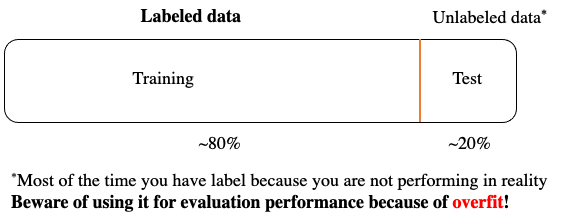

Ok we train on `train` split and we `test` on test split.

**How do we select the distance and $k$ neighbours?**

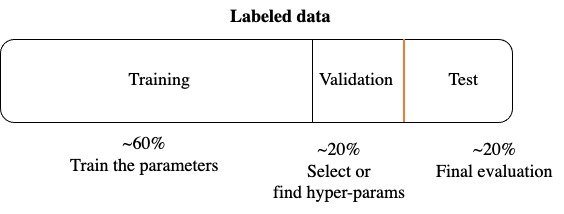

# Set size and partitioning: not a clear definition

<br/>

| Train              	| 70% 	| 60% 	| 80% 	|
|--------------------	|-----	|-----	|-----	|
| Validation _(dev)_ 	| 20% 	| 20% 	| 10% 	|
| Test               	| 10% 	| 20% 	| 10% 	|

# Motivation for each split

- **[Training Set]** Do well on training-set by minimize the loss __(very huge optimistic perf.)__
- **[Validation Set]** Do well in generalization error __(moderate optimistic perf.)__
- **[Test Set]** Get an <ins>estimate</ins> of the generalization error __(no bias on perf.)__

# Problem of a single held out split


- It is **biased** to the **choice made by selecting** that specific validation partition.
- It **wastes part of the training data**
- Even though the hyper-params selected on the validation may be a few, there could be a chance of overfitting
- Think of each cycle "tune training/valid on validation", the dataset will **get rotten iteration over iteration**

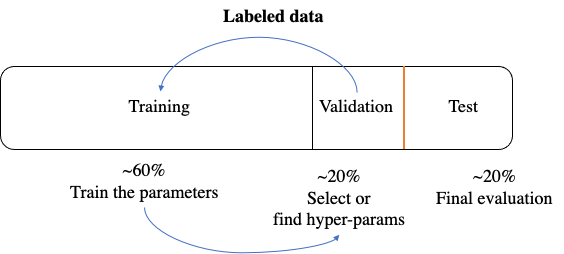

# Nested Cross-Validation

# Nested Cross-Validation

However, by partitioning the **available data into three sets, we drastically reduce the number of samples** which can be used for learning the model, and the **results can depend on a particular random choice** for the pair of (train, validation) sets.
<br/><br/>
<center><img src="figs/grid_search_workflow.png" width="50%" /></center>

# Nested Cross-Validation

A solution to this problem is a procedure called **cross-validation (CV for short)**. 

- A test set should still be held out for final evaluation, 
- Validation set is no longer needed when doing CV.
- **K-fold CV**, the training set is **split into k smaller sets** (below K=5). 

<center><img src="figs/grid_search_cross_validation.png" width="50%" /></center>

# K-fold Cross-Validation
Pro:
- Reduces waste of data
- Unbiased with respect to the split choice
- Provides an estimate of the standard deviation of your prediction (variance)

Con:
- **Computationally expensive!** _(though with multi-core you can run in parallel)_

<center><img src="figs/grid_search_cross_validation.png" width="30%" /></center>

# Which value for K? (10)

In general:
- For larger $K$ , the **error estimation tends to be more accurate**
- but computation time will be greater

Rule of thumb:

- Typical choices for `K` are `2, 5, 10`. 
- By far the most common is **K = 10: 10-fold cross validation.**
- Sometimes **5** is used for efficiency reasons. 
- And sometimes **2 is used for subtle statistical reasons, but that is quite rare**

# What if we have so little data that even K-fold won't work?

# Leave-One-Out (LOO) Cross-Validation

- When $K=N$ then k-fold CV becomes **Leave-one-out (LOO) Cross-Validation** where $N$ is the number of samples you have.
- **PRO**: may be applied in a low data regime
- **CONS**: it tends to overestimate generalization error

<center><img src="figs/LOO.png" width="40%" /></center>

# Leave-One-Out (LOO) Cross-Validation

- LOO is **more computationally expensive** than K-fold cross validation (not so expensive for _K-NN_).

- In terms of accuracy, **LOO often results in high variance as an estimator for the test error**.

- Since  the  samples are used to build each model, models constructed from folds are virtually identical to each other and to the model built from the entire training set.

_As a general rule, most authors, and empirical evidence, suggest that 5- or 10- fold cross validation should be preferred to LOO._

# Cross-Validation Pseudo-Code

Note sklearn provides interface for this but is <ins>mandatory to have in your mind the entire flow:</ins>
<br/>
<center><img src="figs/CV_cimi.png" width="60%" /></center>

# CV works if the data is sampled i.i.d. from same distribution

- **[person identification]** We might try to classify every pixel in an image based on whether it contains a person or not.
- If we have 100 training images, each with 10,000 pixels, then we have a total of 1M training examples. The classification for a pixel in image 5 is highly dependent on the classification for a neighboring pixel in the same image. So if one of those pixels happens to fall in training data, and the other in development (or cross validation) data, your model will do unreasonably well.

- In this case, it is important that when you cross validate (or use development data), **you do so over images, not over pixels.**

- The same goes for **text problems** where you sometimes want to classify things at a word level, but are handed a collection of documents. The important thing to keep in mind is that it is the **images (or documents) that are drawn independently from your data distribution and not the pixels (or words), which are drawn dependently.**

# What to do after CV?

After running cross validation, you have **2 choices.**

1. You can either select **one of the K trained models as your final model** to make predictions
2. You can train a **new model on all of the data, using the hyperparameters selected by cross-validation.** 

_2. is generally preferred to 1._


<center><img src="figs/grid_search_workflow.png" width="50%" /></center>

# Practical Example

We are working in the medical sector and we are using decision tree for their interpretability power, but we have to decide the **depth of the tree.**

<br/><br/>
<center><img src="figs/CV_choice.png" width="70%" /></center>

**Exam look-alike question**: how many models (decision trees here) you need to train to make the choice?

# CV Application Caveat

CV assumptions: 
- Data is Independent and Identically Distributed (i.i.d.) aka, all samples stem from the same generative process 
- The generative process is assumed to have no memory of past generated samples.

⚠️

<center><img src="figs/CV_warning.png" width="80%" /></center>

# Truly i.i.d. $\rightarrow$ K-fold

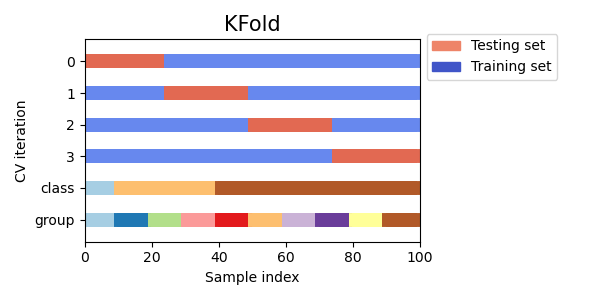

# Truly i.i.d. $\rightarrow$ K-fold

- Unaware of class and groups

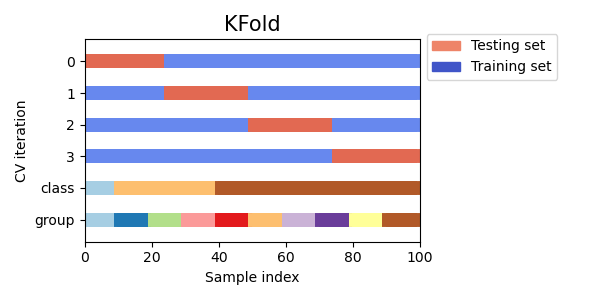

# Strong Class Imbalance $\rightarrow$ Stratified K-fold

- Preserves the **class ratios in both train and test dataset.**

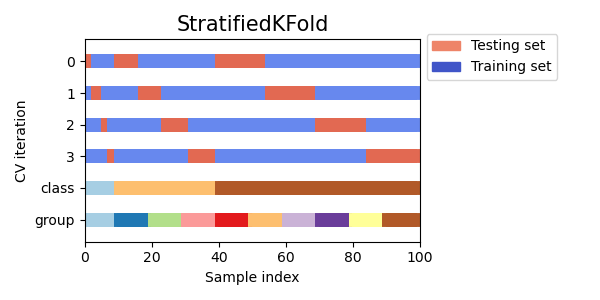

# Unseen Group in test $\rightarrow$ Group k-fold

Ensures that the same group is **NOT** represented in both testing and training sets. _For example if the data is obtained from different subjects with several samples per-subject and if the model is flexible enough to learn from highly person specific features it could fail to generalize to new subjects._

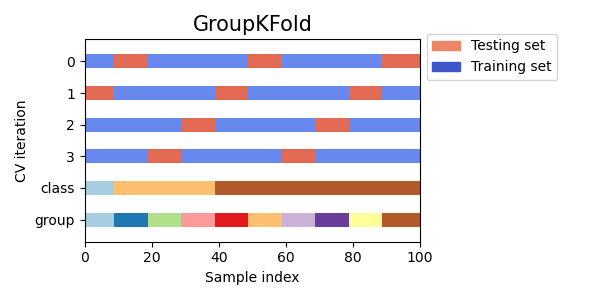

# 2) Hyper-parameter tuning of an estimator

# Hyper-parameter: definition

#### Hyper-parameters are parameters that are not directly learnt within estimators.

- how should you set k in k-NN?
- how deep should the decision tree be?
- how many ensemble? (though you can use OOB)
- how many K centroids in K-means used a proxy for supervised learning
- how many layers of my Neural Networks?

# Recipe

A search of HP consists of:

- an estimator **(example: SVM or Decision Tree)**
- a parameter space; **($k \in [1,3,5,7,11]$ )**
- a method for searching or sampling candidates; **(exhaustive grid search)**
- a cross-validation scheme; **(10-fold CV)**
- a score function **(accuracy)**

# Hyper-parameter tuning

We are working in the medical sector and we are using decision trees for their interpretability power, but we have to decide the **depth of the tree.**

<br/><br/>
<center><img src="figs/hyperparams.png" width="70%" /></center>

# What happens if we have to chose/validate 2 hyper-params?

```python
max_depth=None,  # we know the best for this is 3 but what about the other?
min_impurity_decrease=0.0
```


# Grid Search on a "plane" of hyper-params

```python
max_depth=None,  # we know the best for this is 3 but what about the other?
min_impurity_decrease=0.0
```
<center><img src="figs/grid_search_table.png" width="70%" /></center>

# How many models do we train with k=10 fold cross-validation and grid search over depth $\in [1,2,3]$ and min impurity decrease in $\{0.01,0.1\}$?

#  😱 Grid Search on a "4D-cube" of hyper-params

```python
max_depth=None, 
min_impurity_decrease=0.0
min_samples_leaf=1, 
max_leaf_nodes=None, 
```

# Method for searching

- **Exhaustive Grid Search** (brute force all the HP in CV given predefined ranges) **Mostly used**
- **Randomized Parameter Optimization** (distribution over parameters $\rightarrow$ sample; sample size or budget)
- **Searching for optimal parameters with successive halving** (tournament among candidates parameter)

# Grid Search

```python
# Set the parameters by cross-validation
tuned_parameters = [
    {"max_depth": [1, 2, 3, None],
     "min_impurity_decrease": [0.001, 0.01, 0.1, ],
     "criterion": ["gini", "entropy"],
    }
]
....
clf = GridSearchCV(DTC(), tuned_parameters, scoring="%s" % score)
```

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier as DTC

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [
    {"max_depth": [1, 2, 3, None],
     "min_impurity_decrease": [0.001, 0.01, 0.1, ],
     "criterion": ["gini", "entropy"],
    }
]

scores = ["accuracy"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(DTC(), tuned_parameters, scoring="%s" % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': None, 'min_impurity_decrease': 0.001}

Grid scores on development set:

0.209 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_impurity_decrease': 0.001}
0.209 (+/-0.007) for {'criterion': 'gini', 'max_depth': 1, 'min_impurity_decrease': 0.01}
0.107 (+/-0.003) for {'criterion': 'gini', 'max_depth': 1, 'min_impurity_decrease': 0.1}
0.328 (+/-0.007) for {'criterion': 'gini', 'max_depth': 2, 'min_impurity_decrease': 0.001}
0.328 (+/-0.007) for {'criterion': 'gini', 'max_depth': 2, 'min_impurity_decrease': 0.01}
0.107 (+/-0.003) for {'criterion': 'gini', 'max_depth': 2, 'min_impurity_decrease': 0.1}
0.479 (+/-0.026) for {'criterion': 'gini', 'max_depth': 3, 'min_impurity_decrease': 0.001}
0.478 (+/-0.024) for {'criterion': 'gini', 'max_depth': 3, 'min_impurity_decrease': 0.01}
0.107 (+/-0.003) for {'criterion': 'gini', 'max_depth': 3, 'min_impurity_decrease'

# Randomized Parameter Optimization

- A budget can be chosen independent of the number of parameters and possible values.

- Adding parameters that do not influence the performance does not decrease efficiency.

```python
{'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
  'kernel': ['rbf'], 'class_weight':['balanced', None]}
```


```python
n_iter int, default=10
Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
```

# Searching for optimal parameters with successive halving

**Idea:** Successive halving (SH) is like a **tournament among candidate parameter combinations.**

- SH is an iterative selection process where all candidates (the parameter combinations) are evaluated with a small amount of resources at the first iteration. 
- Only some of these candidates are selected for the next iteration, which will be allocated more resources. 
    - For parameter tuning, the resource is typically the `number of training samples`, but it can also be an arbitrary numeric parameter such as `n_estimators` in a random forest.

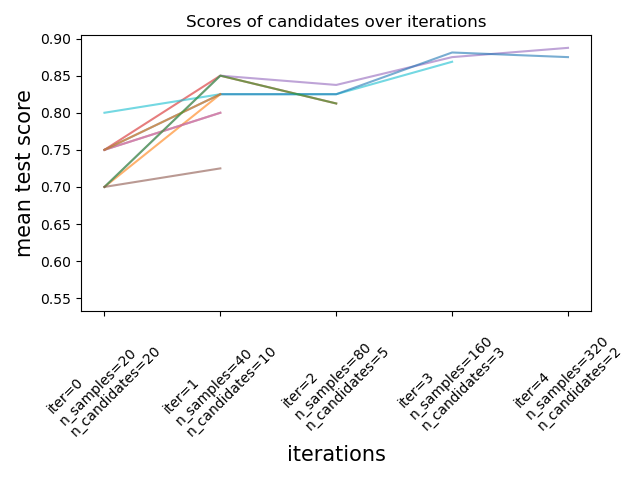

[Searching for optimal parameters with successive halving](https://scikit-learn.org/stable/modules/grid_search.html#searching-for-optimal-parameters-with-successive-halving)

# Artificial Intelligence and Machine Learning

## Unit II

## Evaluation Metrics

# OPIS for Course Evaluation

##  New OPIS Code: 4UZC1KQA


<u>The code and guide are in the google classroom! </u>

Guide on how to evaluate with OPIS (Opinion of the students):

https://www.uniroma1.it/sites/default/files/field_file_allegati/vademecum_per_studenti_opis_2022_23.pdf 🇮🇹

https://www.uniroma1.it/sites/default/files/field_file_allegati/guided_path_to_access_student_s_opinions_questionnaire_2022_2023.pdf 🇺🇸


# Before moving to metrics, let's see hypothetical question about Decision trees in the exam

# Decision Tree Sample Question in the Exam


| Person ID<br>(training example)| Overcooked pasta? 	| Waiting Time 	| Rude Waiter? 	| Satisfied $y$ |
|---|---|---|---|---|
| $\mathbf{x}_1$ 	| Yes 	| Long 	| No 	| 1 (yes) 	|
| $\mathbf{x}_2$ 	| No 	| Short  	| Yes 	| 1 (yes) |
| $\mathbf{x}_3$ 	| Yes 	| Long 	| Yes 	| 0 (no) 	|
| $\mathbf{x}_4$ 	| No 	| Long 	| Yes 	| 1 (yes) 	|
| $\mathbf{x}_5$ 	| Yes 	| Short 	| Yes 	| 0 (no) |


1. Using the training data, construct **a decision tree** for the **binary classification** of customers of
the restaurant “Mama’s Pasta” into ‘Satisfied (1)’ or ‘Unsatisfied (0)’.
2. Use the **Information Gain (IG)** as the decision criterion to select which attribute to split on. Show your calculations for the IG for all possible attributes for every split.

[Taken from U. of Toronto; you can practice more with this](https://www.cs.toronto.edu/~urtasun/courses/CSC411_Fall16/HW1_final.pdf)

# Decision Tree Sample Question in the Exam

| Person ID<br>(training example) | [Feat. 1]<br/>Overcooked pasta? | [Feat. 2]<br/>Waiting Time | [Feat. 3]<br/>Rude Waiter? 	| Satisfied $y$ |
|--------------|------|-------|------|-----------|
| $\mathbf{x}_1$ | Yes  | Long  | No   | 1 (yes)   |
| $\mathbf{x}_2$ | No   | Short | Yes  | 1 (yes)   |
| $\mathbf{x}_3$ | Yes  | Long  | Yes  | 0 (no)    |
| $\mathbf{x}_4$ | No   | Long  | Yes  | 1 (yes)   |
| $\mathbf{x}_5$ | Yes  | Short | Yes  | 0 (no)    |

How to approach this, First, Analysis:
- the features $\mbf{x}$ are not in $\mathbb{R}$ but **categorical variables** in 3 dimensions. In some sense, it is easier to do it manually with variables like this. 
    - Feature 1 is $\{Yes, No\}$
    - Feature 2 is $\{Long, Short\}$
    - Feature 3 is $\{Yes, No\}$
- the target $y$ is **binary categorical variable**  $\{Satisfied~(yes), UnSatisfied~(no)\}$

# Sketch of Solution

| Person ID<br>(training example) 	| [Feat. 1]<br/>Overcooked pasta? 	| [Feat. 2]<br/>Waiting Time 	| [Feat. 3]<br/>Rude Waiter? 	| Satisfied $y$ 	|
|---|---|---|---|---|
| $\mathbf{x}_1$ 	| Yes 	| Long 	| No 	| 1 (yes) 	|
| $\mathbf{x}_2$ 	| No 	| Short  	| Yes 	| 1 (yes) 	|
| $\mathbf{x}_3$ 	| Yes 	| Long 	| Yes 	| 0 (no) 	|
| $\mathbf{x}_4$ 	| No 	| Long 	| Yes 	| 1 (yes) 	|
| $\mathbf{x}_5$ 	| Yes 	| Short 	| Yes 	| 0 (no) 	|


- What is the Entropy of the $y$ with **no split taken**?
    - How many training samples we have: *5*
    - __Over 5 samples__ we have **3 yes and 2 no**
    
So the starting set if $\vert S \vert = 5$, and $H(S)=-\sum_{y \in \{yes,no\}} p(y)\log_2(p(y))$

Over $S$, $p(y==yes) = \frac{3}{5}$ while $p(y==no) = \frac{2}{5}$

So,  $H(S)= -\frac{3}{5}\log_2(\frac{3}{5})-\frac{2}{5}\log_2(\frac{2}{5}) \approx 0.971$

# Sketch of Solution

| Person ID<br>(training example) 	| [Feat. 1]<br/>Overcooked pasta? 	| [Feat. 2]<br/>Waiting Time 	| [Feat. 3]<br/>Rude Waiter? 	| Satisfied $y$ 	|
|---|---|---|---|---|
| $\mathbf{x}_1$ 	| Yes 	| Long 	| No 	| 1 (yes) 	|
| $\mathbf{x}_2$ 	| No 	| Short  	| Yes 	| 1 (yes) 	|
| $\mathbf{x}_3$ 	| Yes 	| Long 	| Yes 	| 0 (no) 	|
| $\mathbf{x}_4$ 	| No 	| Long 	| Yes 	| 1 (yes) 	|
| $\mathbf{x}_5$ 	| Yes 	| Short 	| Yes 	| 0 (no) 	|


- $H(S)= -\frac{3}{5}\log_2(\frac{3}{5})-\frac{2}{5}\log_2(\frac{2}{5}) \approx 0.971$
- Now we have to just "brute force" all the possible splits (3) as if we took the split and compute the weighted entropy after.
- Split on **Overcooked pasta** and compute the new Entropy. I have two case:
    - A) $\rightarrow\texttt{Ov. pasta==Yes}$ I have 3 samples over the "parent" 5 so i have to weight this as $\frac{3}{5}$
    - B) $\texttt{Ov. pasta==No}$ I have 2 samples over the "parent" 5 so i have to weight this as $\frac{2}{5}$

$\frac{3}{5}H(y~|~\texttt{Ov. pasta==Yes}) = ~~\texttt{?}$

# Sketch of Solution

| Person ID<br>(training example) 	| [Feat. 1]<br/>Overcooked pasta? 	| [Feat. 2]<br/>Waiting Time 	| [Feat. 3]<br/>Rude Waiter? 	| Satisfied $y$ 	|
|---|---|---|---|---|
| $\mathbf{x}_1$ 	| Yes 	| Long 	| No 	| 1 (yes) 	|
| $\mathbf{x}_2$ 	| No 	| Short  	| Yes 	| 1 (yes) 	|
| $\mathbf{x}_3$ 	| Yes 	| Long 	| Yes 	| 0 (no) 	|
| $\mathbf{x}_4$ 	| No 	| Long 	| Yes 	| 1 (yes) 	|
| $\mathbf{x}_5$ 	| Yes 	| Short 	| Yes 	| 0 (no) 	|


- $H(S)= -\frac{3}{5}\log_2(\frac{3}{5})-\frac{2}{5}\log_2(\frac{2}{5}) \approx 0.971$
- Now we have to just "brute force" all the possible splits (3) as if we took the split and compute the weighted entropy after.
- Split on **Overcooked pasta** and compute the new Entropy. I have two case:
    - A) $\texttt{Ov. pasta==Yes}$ I have 3 samples over the "parent" 5 so i have to weight this as $\frac{3}{5}$
    - B) $\texttt{Ov. pasta==No}$ I have 2 samples over the "parent" 5 so i have to weight this as $\frac{2}{5}$
    
- Now **look at the labels** for  $\texttt{Ov. pasta==Yes}$
$$\frac{3}{5}H(y~|~\texttt{Ov. pasta==Yes}) = \frac{3}{5} \cdot \biggl[-\sum_{y \in \{yes,no\}} p(y|x)\log_2(p(y|x))\biggl]$$

we have **2 No Satisfaction and 1 Yes,Satisfaction , over 3 samples after choosing**:

$$\frac{3}{5}H(y~|~\texttt{Ov. pasta==Yes}) =\frac{3}{5}\cdot \big[ \underbrace{-\frac{1}{3}\log_2(\frac{1}{3})}_{yes}-\underbrace{\frac{2}{3}\log_2(\frac{2}{3})}_{no}\big] \approx 0.551$$

# Sketch of Solution

| Person ID<br>(training example) 	| [Feat. 1]<br/>Overcooked pasta? 	| [Feat. 2]<br/>Waiting Time 	| [Feat. 3]<br/>Rude Waiter? 	| Satisfied $y$ 	|
|---|---|---|---|---|
| $\mathbf{x}_1$ 	| Yes 	| Long 	| No 	| 1 (yes) 	|
| $\mathbf{x}_2$ 	| No 	| Short  	| Yes 	| 1 (yes) 	|
| $\mathbf{x}_3$ 	| Yes 	| Long 	| Yes 	| 0 (no) 	|
| $\mathbf{x}_4$ 	| No 	| Long 	| Yes 	| 1 (yes) 	|
| $\mathbf{x}_5$ 	| Yes 	| Short 	| Yes 	| 0 (no) 	|


- $H(S)= -\frac{3}{5}\log_2(\frac{3}{5})-\frac{2}{5}\log_2(\frac{2}{5}) \approx 0.971$
- Now we have to just "brute force" all the possible splits (3) as if we took the split and compute the weighted entropy after.
- Split on **Overcooked pasta** and compute the new Entropy. I have two case:
    - A) $\texttt{Ov. pasta==Yes}$ I have 3 samples over the "parent" 5 so i have to weight this as $\frac{3}{5}$
    - B) $\rightarrow \texttt{Ov. pasta==No}$ I have 2 samples over the "parent" 5 so i have to weight this as $\frac{2}{5}$
    
- Now **look at the labels** for  $\texttt{Ov. pasta==No}$
$$\frac{2}{5}H(y~|~\texttt{Ov. pasta==No}) = \frac{2}{5} \cdot \biggl[-\sum_{y \in \{yes,no\}} p(y|x)\log_2(p(y|x))\biggl]$$

we have **0 UnSatisfaction and 2 Yes, Satisfaction , over 2 samples after choosing**:

$$\frac{2}{5}H(y~|~\texttt{Ov. pasta==No}) =\frac{2}{5}\cdot \big[ -\frac{0}{2}\log_2(\frac{0}{2})-\frac{2}{2}\log_2(\frac{2}{2}) \big] = 0$$

# Sketch of Solution

| Person ID<br>(training example) 	| [Feat. 1]<br/>Overcooked pasta? 	| [Feat. 2]<br/>Waiting Time 	| [Feat. 3]<br/>Rude Waiter? 	| Satisfied $y$ 	|
|---|---|---|---|---|
| $\mathbf{x}_1$ 	| Yes 	| Long 	| No 	| 1 (yes) 	|
| $\mathbf{x}_2$ 	| No 	| Short  	| Yes 	| 1 (yes) 	|
| $\mathbf{x}_3$ 	| Yes 	| Long 	| Yes 	| 0 (no) 	|
| $\mathbf{x}_4$ 	| No 	| Long 	| Yes 	| 1 (yes) 	|
| $\mathbf{x}_5$ 	| Yes 	| Short 	| Yes 	| 0 (no) 	|


- $H(S)= -\frac{3}{5}\log_2(\frac{3}{5})-\frac{2}{5}\log_2(\frac{2}{5}) \approx 0.971$
- Now we have to just "brute force" all the possible splits (3) as if we took the split and compute the weighted entropy after.
- Split on **Overcooked pasta** and compute the new Entropy. I have two case:
    - A) $\texttt{Ov. pasta==Yes}$ I have 3 samples over the "parent" 5 so i have to weight this as $\frac{3}{5}$
    - B) $\texttt{Ov. pasta==No}$ I have 2 samples over the "parent" 5 so i have to weight this as $\frac{2}{5}$


Information Gain for split on $\texttt{Overcooked pasta}$:

$$IG(Y~|~\texttt{Ov. pasta}) \doteq \frac{5}{5}H(S) - \Big[ \frac{2}{5}H(y~|~\texttt{Ov. pasta==No}) + \frac{3}{5}H(y~|~\texttt{Ov. pasta==Yes}) \Big] $$
$$IG(Y~|~\texttt{Ov. pasta}) \doteq   0.971 - [0.551+0] \approx 0.42 $$

# We are done only for 1/3 of the features.
## Now we have to keep repeating this for the other 2 features and then split on the feature with the <ins/> maximum IG </ins>

| Split Feature 	| IG 	|
|---|---|
| Overcooked Pasta 	| 0.42 	|
| Waiting Time 	| ?	|
| Rude Waiter 	| ? 	|

# Fast Forward

| Split Feature 	| IG 	|
|---|---|
| **Overcooked Pasta** 	| **0.42** 	|
| Waiting Time 	| 0.020  	|
| Rude Waiter 	| 0.171 	|

So we split on `Overcooked Pasta over Yes` with a gain of $0.42$

- Note that `Overcooked Pasta` is a binary variable so splitting over Yes or Not does not matter.
- If `Overcooked Pasta` were $\{Yes, No, Maybe\}$ we should have splitted taking note of the threshold. 
    -i.e. if we binary split on **Yes**, the other split is $\neg$ `Yes` (which means it could be `No` or `Maybe`).

# So now the problem is:

## Split Overcooked pasta == Yes 

| Person ID<br>(training example) 	| ~~[Feat. 1]<br/>Overcooked pasta?~~ 	| [Feat. 2]<br/>Waiting Time 	| [Feat. 3]<br/>Rude Waiter? 	| Satisfied $y$ 	|
|---|---|---|---|---|
| $\mathbf{x}_1$ 	| ~~Yes~~ 	| Long 	| No 	| 1 (yes) 	|
| $\mathbf{x}_3$ 	| ~~Yes~~ 	| Long 	| Yes 	| 0 (no) 	|
| $\mathbf{x}_5$ 	| ~~Yes~~ 	| Short 	| Yes 	| 0 (no) 	|


## Split Overcooked pasta == No 

| Person ID<br>(training example) 	| ~~[Feat. 1]<br/>Overcooked pasta?~~ 	| [Feat. 2]<br/>Waiting Time 	| [Feat. 3]<br/>Rude Waiter? 	| Satisfied $y$ 	|
|---|---|---|---|---|
| $\mathbf{x}_2$ 	| ~~No~~ 	| Short  	| Yes 	| 1 (yes) 	|
| $\mathbf{x}_4$ 	| ~~No~~ 	| Long 	| Yes 	| 1 (yes) 	|

# And the tree is:

<center><img src='figs/decision_tree_manual2.png' width='70%'/></center>

# 3) Metrics for evaluation [mainly for classification]


# Why evaluation metrics
- Training objective (cost function) is only a proxy for real world objective.
- Metrics help capture a business goal into a quantitative target (not all errors are equal).
- Helps organize ML team effort towards that target.
- Generally in the form of improving that metric on the dev set.
- Useful to quantify the “gap” between:
    - Desired performance and baseline (estimate effort initially).
    - Desired performance and current performance.
- Useful for lower level tasks and debugging (like diagnosing bias vs variance).
- Ideally training objective should be the metric, but not always possible. Still, metrics are useful and important for evaluation.

# Binary Classification

- $\mbf{x}$ is input, $y$ is binary takes value in $\{0,1\}$
- The model is $\hat{y} = h(\mbf{x})$
- Two type of models:
    1. Models that outputs a categorical class directly (K-NN, Decision Trees)
    2. Model that outputs a **real value aka probability $\in [0,1]$** (Logistic Regression, SVM)

# Score of Binary Classifier
<br/>
<center><img src="figs/score_model.png" width="60%" /></center>

[Picture taken from Stanford Slide (copyright by Anand Avati)](http://cs229.stanford.edu/summer2019/EvaluationMetrics.pptx)

# Score of Binary Classifier works with  a Threshold
<br/>

<center><img src="figs/score_model_threshold.png" width="50%" /></center>

[Picture taken from Stanford Slide](http://cs229.stanford.edu/summer2019/EvaluationMetrics.pptx)

# Easy Peasy as Accuracy

$$\texttt{accuracy}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1(\hat{y}_i = y_i)$$
<br/>
<center><img src="figs/score_model_threshold.png" width="30%" /></center>

[Picture taken from Stanford Slide](http://cs229.stanford.edu/summer2019/EvaluationMetrics.pptx)

# Relaxation of Accuracy: Top-K Accuracy

$$   \texttt{top-k accuracy}(y, \hat{f}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} \sum_{j=1}^{k} 1(\hat{f}_{i,j} = y_i)$$
<br/>
<center><img src="figs/score_model_threshold.png" width="30%" /></center>

[Picture taken from Stanford Slide](http://cs229.stanford.edu/summer2019/EvaluationMetrics.pptx)

# Beyond Accuracies: Confusion Matrix

# Beyond Accuracies: Confusion Matrix (Binary Case)


<br/>
<center><img src="figs/confusion_matrix.png" width="30%" /></center>

[Picture taken from Stanford Slide](http://cs229.stanford.edu/summer2019/EvaluationMetrics.pptx)

# Confusion Matrix (Multi-class case)

```python
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)
> array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
```

{{import matplotlib.pyplot as plt; from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay;y_true = [2, 0, 2, 2, 0, 1];y_pred = [0, 0, 2, 2, 0, 2];disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred));disp.plot();plt.show()}}

# True Positive


<br/>
<center><img src="figs/TP.png" width="30%" /></center>

[Picture taken from Stanford Slide](http://cs229.stanford.edu/summer2019/EvaluationMetrics.pptx)

# True Negative


<br/>
<center><img src="figs/TN.png" width="30%" /></center>

[Picture taken from Stanford Slide](http://cs229.stanford.edu/summer2019/EvaluationMetrics.pptx)

# False Positive


<br/>
<center><img src="figs/FPp.png" width="30%" /></center>

[Picture taken from Stanford Slide](http://cs229.stanford.edu/summer2019/EvaluationMetrics.pptx)

# False Negative


<br/>
<center><img src="figs/FN.png" width="30%" /></center>

[Picture taken from Stanford Slide](http://cs229.stanford.edu/summer2019/EvaluationMetrics.pptx)

# Next slide will make things more clear

# FP and FN also called Type-1 and Type-2 errors


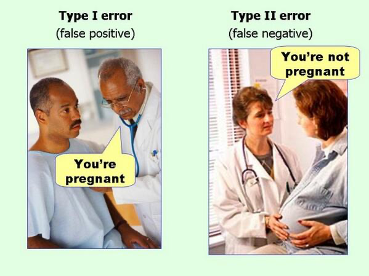

# New view on Accuracy


<br/>
<center><img src="figs/conf_accuracy.png" width="30%" /></center>

[Picture taken from Stanford Slide](http://cs229.stanford.edu/summer2019/EvaluationMetrics.pptx)

#  Precision
_Ability to return only images that match the query_

$$  \text{precision} = \frac{tp}{tp + fp}$$
<br/>
<center><img src="figs/conf_precision.png" width="30%" /></center>


[Picture taken from Stanford Slide](http://cs229.stanford.edu/summer2019/EvaluationMetrics.pptx)

#  Recall
_Ability to return all the images that match the query_

$$ \text{recall} = \frac{tp}{tp + fn} $$
<br/>
<center><img src="figs/conf_recall.png" width="30%" /></center>

[Picture taken from Stanford Slide](http://cs229.stanford.edu/summer2019/EvaluationMetrics.pptx)

# Precision, Recall, F-Measure

$$  \text{precision} = \frac{tp}{tp + fp}$$
$$ \text{recall} = \frac{tp}{tp + fn} $$
$$F_\beta = (1 + \beta^2) \frac{\text{precision} \times \text{recall}}{\beta^2 \text{precision} + \text{recall}} $$

# True Positive Rate, False Positive Rate

$$  \text{TPR} = \frac{tp}{P_{gt}}$$
$$ \text{FPR} = \frac{fp}{N_{gt}} $$

# Summary

<center><img src="figs/tabel_eval.png" width="90%" /></center>

#  Change Threshold $\rightarrow$ New Confusion Matrix


<br/>
<center><img src="figs/conf_change_trs.png" width="30%" /></center>

[Picture taken from Stanford Slide](http://cs229.stanford.edu/summer2019/EvaluationMetrics.pptx)

#  Threshold Scanning $\rightarrow$ ROC Curve


<br/>
<center><img src="figs/conf_trhs_scanning.png" width="80%" /></center>

[Picture taken from Stanford Slide](http://cs229.stanford.edu/summer2019/EvaluationMetrics.pptx)

# ROC - Receiver Operating Characteristic curve

- ROC curve, is a **graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied.**
- It is created by plotting the **fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings.**
- TPR is also known as _sensitivity_, and FPR is one minus the _specificity or true negative rate_.
- ROC and Area under the ROC (AUC) **do not require to compute a threshold**

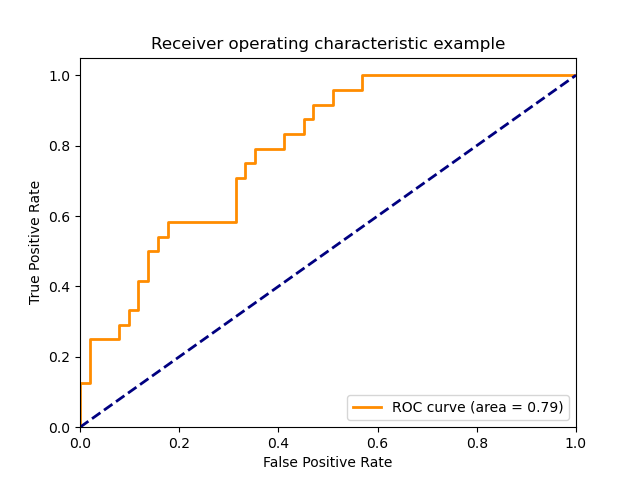

# Computing ROC "manually"

In [4]:
y = np.array([0, 0, 1, 1, 1, 0])
scores = np.array([0.1, 0.4, 0.35, 0.8, 0.01, 0.2])

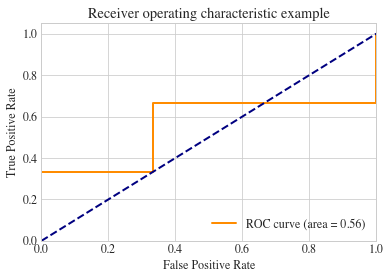

In [5]:
import numpy as np
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, scores, drop_intermediate=False)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [6]:
tpr, fpr, thresholds

(array([0.        , 0.33333333, 0.33333333, 0.66666667, 0.66666667,
        0.66666667, 1.        ]),
 array([0.        , 0.        , 0.33333333, 0.33333333, 0.66666667,
        1.        , 1.        ]),
 array([1.8 , 0.8 , 0.4 , 0.35, 0.2 , 0.1 , 0.01]))

In [7]:
def thrs_count(scores, index, denom, thrs, normalize=True):
    count = sum(scores[index] >= thrs)
    return count/denom if normalize else count


pos = y == 1  # indexing the positive
neg = y == 0  # indexing the negative
n_pos = sum(pos)  # sum the ground-truth positve
n_neg = sum(neg)  # sum the ground-truth negative
sort_scores = sorted(scores, reverse=True)  # sort highest first
sort_scores = [sort_scores[0] + 1] + sort_scores  # add extra point
ROC = [(thrs_count(scores, pos, n_pos, thrs), thrs_count(scores, neg, n_neg, thrs))
       for thrs in sort_scores] # for all thresholds, count TP and FP and normalize them
my_TPR, my_FPR = list(map(lambda *args: args, *ROC)) # reshape

In [8]:
my_TPR, my_FPR, sort_scores

((0.0,
  0.3333333333333333,
  0.3333333333333333,
  0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  1.0),
 (0.0,
  0.0,
  0.3333333333333333,
  0.3333333333333333,
  0.6666666666666666,
  1.0,
  1.0),
 [1.8, 0.8, 0.4, 0.35, 0.2, 0.1, 0.01])

In [9]:
assert all([np.allclose(tpr, my_TPR),
            np.allclose(fpr, my_FPR),
            np.allclose(thresholds, sort_scores)]), 'Your ROC is wrong'

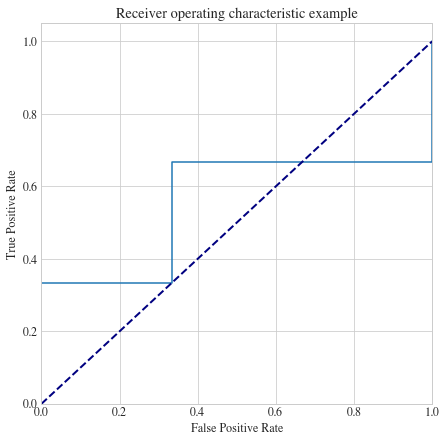

In [10]:
plt.figure(figsize=(7,7))
plt.plot(my_FPR,my_TPR);
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.show()

In [11]:
AUC = np.dot(np.diff(fpr), tpr[1:])
print(AUC)
assert np.allclose(AUC, auc(fpr, tpr)), 'my AUC is WRONG'

0.5555555555555556


# Precision Recall Curve

- Same as ROC but plot **Precision in function of the Recall**
- Unlike ROC can have **zig-zag (non-monotonic) trends**
    - Getting a bunch of positives in the sequence increases both precision and recall (hence curve climbs up slowly)... 
    - but getting a bunch of negatives in the sequence drops the precision without increasing recall. Hence, by definition, curve has only slow climbs and vertical drops
- Instead of AUC we compute **AP (Average Precision)**
    - _Intuition: By randomly picking the threshold, what’s the expected precision?_
- Used in ranking systems (Image Retrieval)

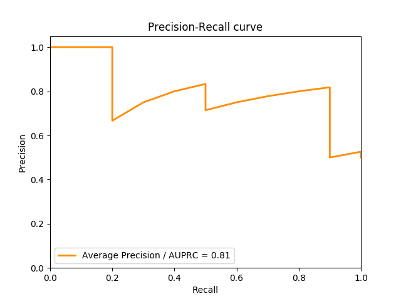


# Precision, Recall, F-Measure

$  \text{precision} = \frac{tp}{tp + fp}$<br/><br/>
$ \text{recall} = \frac{tp}{tp + fn} $  <br/><br/>
$F_\beta = (1 + \beta^2) \frac{\text{precision} \times \text{recall}}{\beta^2 \text{precision} + \text{recall}} $

# Class Imbalance: a big problem

Symptom: Prevalence < 5% (no strict definition) $\frac{P_{gt}}{P_{gt}+N_{gt}}$

- **Accuracy:** Blindly predict majority class you will be mostly right.
- **Log-Loss (penalize wrongly confident predictions):** Majority class can dominate the loss.

$$   L_{\log}(y, p) = -\log \operatorname{Pr}(y|p) = -\big(y \log (p) + (1 - y) \log (1 - p)\big)
 $$
- **AUROC:** Easy to keep AUC high by scoring most negatives very low.
- **AUPRC:** Somewhat more robust than AUROC. But other challenges.

`In general:     Accuracy  <<  AUROC  <<  AUPRC`

# Balanced Accuracy

Avoids inflated performance estimates on imbalanced datasets. 
It is the raw accuracy where each sample **is weighted
according to the inverse prevalence of its true class.**

Thus for balanced datasets, the score is equal to accuracy.

In the binary case, balanced accuracy is equal to the arithmetic mean of
[sensitivity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)
(true positive rate) and [specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) (true negative
rate):

$$  \texttt{balanced-accuracy} = \frac{1}{2}\left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP}\right )$$


# Homework (sample question in an exam)

You are given a machine learning system performing binary classification on $6$ samples.
The ground-truth labels and the unnormalized scores for the six samples are:

| **labels** 	| -1 	| 1   	| -1   	| 1   	| -1   	| 1 |
|--------|----|-----|------|-----|------|-----|
| **score**  	| 1000	| 0.5 	| -0.9 	| 0.8 	| -0.1 	| 0.1 |

The scores are unnormalized (i.e. not probabilities) and **correlated** with the positive label (1). 
- For labels **1** the higher the score the better it is; 
- whereas for labels **-1** the lower the score, the better it is.

1. Compute the ROC with a  table and/or draw it approximatively  the ROC curve (TPR vs FPR)
2. Calculate the Area Under the Curve (AUC).
3. How would you set the score to make $AUC=100\%?$

| **labels** 	| -1 	| 1   	| -1   	| 1   	| -1   	| 1 |
|--------|----|-----|------|-----|------|-----|
| **score**  	| ? 	| ? 	| ? 	| ? 	| ? 	| ? | 

4. How would you set the score to make $AUC=0\%?$

| **labels** 	| -1 	| 1   	| -1   	| 1   	| -1   	| 1 |  
|--------|----|-----|------|-----|------|-----|
| **score**  	| ? 	| ? 	| ? 	| ? 	| ? 	| ? |

5. Considering the score of answer 3, that gives  $AUC=100\%?$, what happens if you multiply the scores by a constant positive value $\alpha > 0$? Is the ROC going to change? What about the AUC?

# Solution

In [12]:
y = np.array([-1, 1, -1, 1, -1, 1])
scores = np.array([1000, 0.5, -0.9, 0.8, -0.1, 0.1])

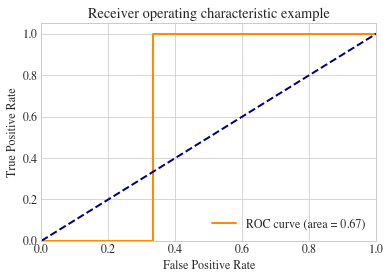

In [13]:
import numpy as np
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, scores, drop_intermediate=False, pos_label=1)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [14]:
pos = y == 1  # indexing the positive
neg = y == -1  # indexing the negative
n_pos = sum(pos)  # sum the ground-truth positve
n_neg = sum(neg)  # sum the ground-truth negative
sort_scores = sorted(scores, reverse=True)  # sort highest first
sort_scores = [sort_scores[0] + 1] + sort_scores  # add extra point
ROC = [(thrs_count(scores, pos, n_pos, thrs, normalize=False),
        thrs_count(scores, neg, n_neg, thrs, normalize=False))
       for thrs in sort_scores]  # for all thresholds, count TP and FP and normalize them
diff_fpr = np.diff(np.array(my_FPR))
my_TPR, my_FPR = list(map(lambda *args: args, *ROC))  # reshape
table = '|thrs 	|tpr 	|fpr 	|diff_fpr 	|\n|--- 	|--- 	|--- 	|--- 	\n'
for count, (mtpr, mfpr, thrs) in enumerate(zip(my_TPR, my_FPR, sort_scores)):
    diff_fpr = mfpr/n_neg-my_FPR[count-1]/n_neg
    table += f'|{thrs} 	|{mtpr}/{n_pos} 	|{mfpr}/{n_neg} 	| { str(diff_fpr)[:5] if count > 0 else 0}	\n'
print(table)

|thrs 	|tpr 	|fpr 	|diff_fpr 	|
|--- 	|--- 	|--- 	|--- 	
|1001.0 	|0/3 	|0/3 	| 0	
|1000.0 	|0/3 	|1/3 	| 0.333	
|0.8 	|1/3 	|1/3 	| 0.0	
|0.5 	|2/3 	|1/3 	| 0.0	
|0.1 	|3/3 	|1/3 	| 0.0	
|-0.1 	|3/3 	|2/3 	| 0.333	
|-0.9 	|3/3 	|3/3 	| 0.333	



# ROC Table
{{print(table)}}

# AUC

$$ \texttt{AUC} = \sum_{t=1}^T \delta_{\text{FPR}_t} \cdot \text{TPR}_t = \boldsymbol{\delta}_{\text{FPR}}^T\cdot\textbf{TPR}$$

$$ \texttt{AUC} = \underbrace{\frac{1}{3}\cdot 0}_{t=1000}+\underbrace{0 \cdot \frac{1}{3}}_{t=0.8}+\underbrace{0 \cdot \frac{2}{3}}_{t=0.5}+\underbrace{0 \cdot \frac{3}{3}}_{t=0.1}+ \underbrace{\frac{1}{3}\cdot\frac{3}{3}}_{t=-0.1} + \underbrace{\frac{1}{3}\cdot\frac{3}{3}}_{t=-0.9} = \frac{2}{3}$$

 - $\delta_{\text{FPR}_t} = FPR_t - FPR_{t-1}$

In [15]:
my_FPR/n_neg

array([0.        , 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.66666667, 1.        ])

In [16]:
np.dot(np.diff(my_FPR/n_neg), (my_TPR/n_pos)[1:])

0.6666666666666667

In [17]:
y = np.array([-1, 1, -1, 1, -1, 1])
alpha = 1
scores = np.array([-alpha, alpha, -alpha, alpha, -alpha, alpha])

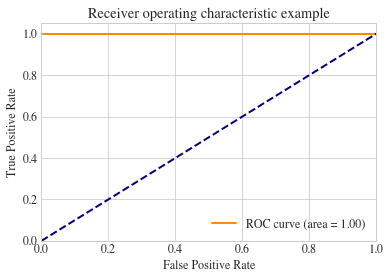

In [18]:
import numpy as np
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, scores, drop_intermediate=False, pos_label=1)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [19]:
y = np.array([-1, 1, -1, 1, -1, 1])
alpha = -1
scores = np.array([-alpha, alpha, -alpha, alpha, -alpha, alpha])

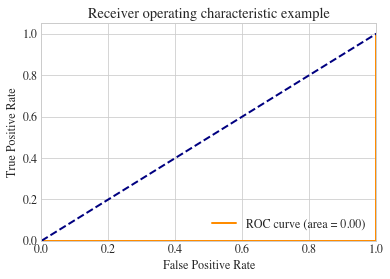

In [20]:
import numpy as np
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, scores, drop_intermediate=False, pos_label=1)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()